# LongFormer

The basic idea would be to represent each document by one or more emebddings (for example one embedding per paragraph), and then you look at the proximity of the embeddings of each document to the others, which will allow you to cluster them.

In [1]:
%%capture
!pip install transformers[sentencepiece] datasets sacremoses evaluate
!pip install umap-learn

In [2]:
import os
import json
import string
from pathlib import Path
from typing import Union
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from tqdm import notebook
from bs4 import BeautifulSoup
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from wordcloud import WordCloud
from tqdm import notebook
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import umap

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Data

In [3]:
#Connection with my drive folder
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
directory = 'drive/MyDrive/Colab_Notebooks/fulltext'

data = dict()

file_list = os.listdir(directory)

for filename in notebook.tqdm(file_list):
    with open(directory + "/" + filename, 'r') as f:
        raw_data = f.read()
    
    bs_data = BeautifulSoup(raw_data,'xml')
    
    texts = list()
    
    if bs_data.findChild('sentences') == None:
        # If there are no sentences, extract the text from each <text> tag
        for tag in bs_data.find_all('text'):
            texts.append(tag)
    else:
        # If there are sentences, extract the text from each <sentences> tag
        for tag in bs_data.find_all('sentences'):
            texts.append(tag)
    
    data[filename] = texts

  0%|          | 0/3890 [00:00<?, ?it/s]

In [5]:
def clean_data(doc:str) -> str:
    x = re.sub(r'\n', ' ', doc) #we remove \n
    x = re.sub(r"\'", ' ', x)
    return x

In [6]:
documents = [clean_data(data[key][0].text) for key in data.keys()]

### LongFormer

The "allenai/longformer-base-4096" model is a pre-trained language model based on the Longformer architecture, which is a variant of the Transformer architecture commonly used in natural language processing (NLP) tasks.

The Longformer architecture was introduced in a research paper by Beltagy et al. in 2020, with the aim of improving the ability of Transformer models to handle long sequences of text. Unlike the original Transformer architecture, which has a fixed attention span that limits the length of the input sequences, the Longformer architecture uses a sliding window mechanism to allow the model to attend to long-range dependencies in the input sequence.

The "allenai/longformer-base-4096" model is trained on a large corpus of text data and has learned to represent text in a way that captures the underlying semantics and structure of the language. It is particularly well-suited for NLP tasks that involve longer sequences of text, such as document classification, summarization, and question answering.

One of the key advantages of the Longformer architecture is its ability to scale to longer sequences without sacrificing performance. This is achieved through a combination of techniques, such as sparse attention, which allows the model to focus on only the most relevant parts of the input sequence, and reversible layers, which allow the model to perform computations more efficiently.

We had memory issues with the large dimension of all the embeddings. But we solved it.

In [7]:
from transformers import LongformerTokenizer, LongformerModel
import torch

In [8]:
device = 'cuda' # or 'cuda:0' if you have multiple GPUs
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096', device=device)
model = LongformerModel.from_pretrained('allenai/longformer-base-4096').to(device)

res = list()
dict_res = dict()
i = 0
for doc in notebook.tqdm(documents):

  inputs = tokenizer(doc, return_tensors='pt', max_length=512, truncation=True, padding=True)

  inputs.to(device)

  outputs = model(**inputs)

  # Extract the last hidden state of the output as the embeddings
  embeddings = outputs.last_hidden_state
  
  # Take the mean of the embeddings along the rows
  embeddings = embeddings.mean(dim=1)

  # Save the mean embeddings to a numpy file
  embeddings = embeddings.flatten().cpu().detach().numpy()

  np.save(f'embeddings_{i}.npy', embeddings)
  # i += 1

  i += 1


Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerModel: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing LongformerModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/3890 [00:00<?, ?it/s]

In [9]:
#@title Load embeddings from disk
embeddings = []
for i in range(len(documents)):
    embedding = np.load(f'embeddings_{i}.npy')
    embeddings.append(embedding)

In [10]:
len(embeddings[10])

768

In [11]:
embs = np.zeros((len(embeddings[10]), len(embeddings)))

In [12]:
for i, embedding in enumerate(embeddings):
  embs[:, i] = embedding

In [13]:
embs

array([[ 0.06685136,  0.0685473 ,  0.0378626 , ...,  0.03493974,
         0.05520425,  0.02968169],
       [ 0.0394853 ,  0.05117439,  0.05540373, ...,  0.16024369,
         0.0875611 , -0.00199443],
       [ 0.09741151,  0.0706351 ,  0.06927747, ...,  0.07942402,
         0.03803336,  0.03497329],
       ...,
       [ 0.12601277,  0.08912962, -0.1467552 , ..., -0.04338001,
        -0.12367702,  0.03868978],
       [ 0.07162274,  0.0694674 ,  0.02090349, ..., -0.02321198,
         0.04855823,  0.05000385],
       [ 0.04436871,  0.06392528,  0.04733748, ..., -0.01237908,
         0.05211508,  0.07293986]])

## t-SNE
t-SNE (t-Distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique commonly used for visualizing high-dimensional data in a lower-dimensional space. It is particularly effective at preserving the structure of the original data and revealing patterns that might not be evident in the high-dimensional space.

The t-SNE algorithm works by modeling the high-dimensional data as a probability distribution and then modeling the low-dimensional data as a different probability distribution. The two probability distributions are compared and adjusted until they match as closely as possible. This approach results in a low-dimensional representation of the data that preserves its structure, allowing for meaningful visualization and analysis.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


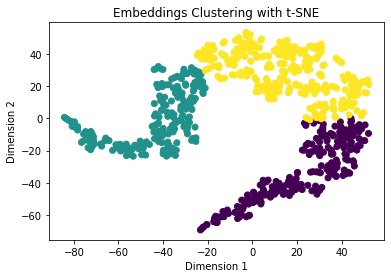

In [14]:
#@title TSNE + Kmeans
# Reduce dimensionality with t-SNE
tsne = TSNE(n_components=2, perplexity=5, random_state=0)
embeddings_tsne = tsne.fit_transform(embs)

# Cluster embeddings using KMeans
kmeans = KMeans(n_clusters=3).fit(embeddings_tsne)
labels = kmeans.labels_

# Generate scatter plot
plt.scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1], c=labels)
plt.title('Embeddings Clustering with t-SNE')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()

We have successfully mapped them onto a 2D space, which is a noteworthy achievement. It is evident that the documents are not randomly distributed, which is crucial. The application of t-SNE allows us to conclude that the documents are not randomly distributed. The subsequent clustering using K-means is optional and dependent on the specific business requirements. Ultimately, the choice of whether to use clustering or not will depend on their specific domain needs.
From an analysis point of view there is a kind of progression in the documents but the interpretation depends on the business domain


*It should be noted that while clustering following t-SNE can yield results, there is always the possibility that the discovered "clusters" are simply artifacts of the t-SNE algorithm. This means that their validity may be questionable, and it may not be possible to provide a clear explanation for their existence. It is important to acknowledge the possibility of perceiving patterns that are not truly present, akin to seeing shapes in clouds. Therefore, it is crucial to approach the results with a critical eye and ensure that they are substantiated by additional evidence and insights.*

## UMAP

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique similar to t-SNE, but with some advantages such as being faster and allowing for more control over the parameters. UMAP can be used to transform high-dimensional data into a lower-dimensional representation that retains the original data's structure.

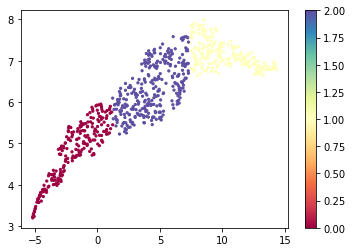

In [17]:
#@title UMAP + Kmeans
# Create embeddings using UMAP
reducer = umap.UMAP(random_state=42)
embeddings = reducer.fit_transform(embs)

# Cluster embeddings using k-means
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
labels = kmeans.fit_predict(embeddings)

# Plot the clusters
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=labels, cmap='Spectral', s=5)
plt.colorbar()
plt.show()


The graphs do not resemble each other but we are still in the continuity of the 3 clusters


**If we had more time**

We could compare the documents between them using the distance in space between the embeddings